In [24]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from util.torch_architecture import CNN
from util.cnn_parameters import IMG_HEIGHT, IMG_WIDTH, TEST_IMAGES_PATH

import os

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN()
model.load_state_dict(torch.load("cats_dogs_cnn.pth", map_location=device))
model.to(device)
model.eval()

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=

In [26]:
def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
        transforms.ToTensor(),
    ])

    input_image = transform(image).unsqueeze(0)  
    return input_image.to(device)

In [27]:
def gradcam_method(model, input_image, target_class, target_layer_name='model.20'):
    model.eval()
    input_image = input_image.to(next(model.parameters()).device)
    
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations["value"] = output.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients["value"] = grad_out[0].detach()


    target_layer = dict(model.named_modules())[target_layer_name]
    handle_fw = target_layer.register_forward_hook(forward_hook)
    handle_bw = target_layer.register_backward_hook(backward_hook)

   
    output = model(input_image)
    class_score = output[0, 0] if target_class == 1 else 1 - output[0, 0]

    
    model.zero_grad()
    class_score.backward()

    grads = gradients["value"]
    acts = activations["value"]

    weights = grads.mean(dim=(2, 3), keepdim=True)
    cam = (weights * acts).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=(input_image.shape[2], input_image.shape[3]), mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu()

    cam -= cam.min()
    cam /= cam.max()

    handle_fw.remove()
    handle_bw.remove()

    return output, cam


In [28]:
def plot_gradcam(input_image, cam):
    image_np = input_image.squeeze().permute(1, 2, 0).cpu().numpy()
    heatmap = cam.numpy()

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image_np, alpha=0.6)
    plt.imshow(heatmap, cmap='jet', alpha=0.4)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Model output (sigmoid): 0.9848


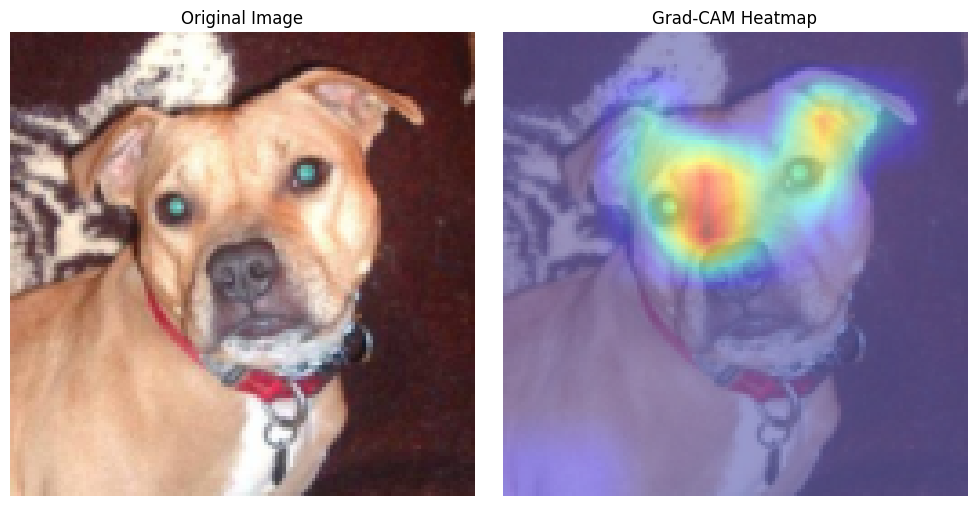

In [29]:
image_path = os.path.join(TEST_IMAGES_PATH, "2.jpg")  
input_img = prepare_image(image_path)

target_class = 1

output, cam = gradcam_method(model, input_img, target_class, target_layer_name='model.20')

print(f"Model output (sigmoid): {output.item():.4f}")
plot_gradcam(input_img, cam)


In [30]:
from dataclasses import dataclass
from typing import Callable
from scipy.stats import pearsonr


DAUC = "DAUC"
IAUC = "IAUC"
DELETION = "Deletion"
INSERTION = "Insertion"

@dataclass
class CorrMetricsParams:
    perturbed_image: Callable
    mask: Callable
    label: str

def cloned_image(input_image):
    return input_image.clone()

def zeros_image(input_image):
    return torch.zeros_like(input_image)

def mask_set_zero(abs_relevance, num_remove, sorted_indices):
    mask = torch.ones_like(abs_relevance.view(-1))
    mask[sorted_indices[:num_remove]] = 0
    return mask

def mask_set_one(abs_relevance, num_add, sorted_indices):
    mask = torch.zeros_like(abs_relevance.view(-1))
    mask[sorted_indices[:num_add]] = 1
    return mask

del_corr = CorrMetricsParams(
    perturbed_image=cloned_image,
    mask=mask_set_zero,
    label="removed"
)

ins_corr = CorrMetricsParams(
    perturbed_image=zeros_image,
    mask=mask_set_one,
    label="added"
)

metrics_params = {
    DAUC: True,
    IAUC: False,
    DELETION: del_corr,
    INSERTION: ins_corr,
}

def apply_mask(input_image, mask, abs_relevance):
    mask = mask.view(abs_relevance.shape).unsqueeze(0).repeat(3, 1, 1)
    perturbed_image = input_image * mask
    return perturbed_image

def get_abs_relevance(relevance):
    return relevance.unsqueeze(0) if relevance.ndim == 2 else relevance

def get_num_pixels(input_image):
    return input_image.shape[2] * input_image.shape[3]


In [31]:
def compute_auc(model, input_image, output, relevance, auc, steps=10, plot=False):
    model.eval()

    abs_relevance = get_abs_relevance(relevance).abs().sum(1)[0] 
    sorted_indices = abs_relevance.view(-1).argsort(descending=metrics_params[auc])

    perturbation_curve = []
    num_pixels = get_num_pixels(input_image)

    for step in range(1, steps + 1):
        num_remove = int((step / steps) * num_pixels)
        mask = mask_set_zero(abs_relevance, num_remove, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, abs_relevance)

        with torch.no_grad():
            output = model(perturbed_image)

        perturbation_curve.append(output.item())

    x_vals = np.linspace(0, 1, steps)
    auc_value = np.trapz(perturbation_curve, x_vals)

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(x_vals, perturbation_curve, marker='o', label="Score Curve")
        plt.xlabel("Fraction of pixels occluded" if auc == DAUC else "Fraction of least relevant pixels added")
        plt.ylabel("Model Output Score")
        plt.title(f"{auc} Evaluation (AUC = {auc_value:.4f})")
        plt.legend()
        plt.show()

    return auc_value, perturbation_curve

def compute_ins_del_correlation(model, input_image, output, relevance, corr, steps=10, plot=False):
    model.eval()

    abs_relevance = get_abs_relevance(relevance).abs().sum(1)[0]  
    sorted_indices = abs_relevance.view(-1).argsort(descending=True)

    perturbed_image = metrics_params[corr].perturbed_image(input_image)
    perturbation_curve = []
    num_pixels = get_num_pixels(input_image)

    for step in range(1, steps + 1):
        num_remove = int((step / steps) * num_pixels)

        mask = metrics_params[corr].mask(abs_relevance, num_remove, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, abs_relevance)

        with torch.no_grad():
            output = model(perturbed_image)

        perturbation_curve.append(output.item())

    x_vals = np.linspace(0, 1, steps)
    correlation, _ = pearsonr(x_vals, perturbation_curve)

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(x_vals, perturbation_curve, marker='o', label="Score Drop")
        plt.xlabel(f"Fraction of pixels {metrics_params[corr].label}")
        plt.ylabel("Model Output Score")
        plt.title(f"{corr} Correlation = {correlation:.4f}")
        plt.legend()
        plt.show()

    return correlation

def compute_average_drop(model, input_image, output, relevance, steps=10, plot=False):
    model.eval()

    abs_relevance = get_abs_relevance(relevance).abs().sum(1)[0]
    sorted_indices = abs_relevance.view(-1).argsort(descending=True)

    drop_curve = []
    initial_output = model(input_image).item()
    num_pixels = get_num_pixels(input_image)

    for step in range(1, steps + 1):
        num_remove = int((step / steps) * num_pixels)
        mask = mask_set_zero(abs_relevance, num_remove, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, abs_relevance)

        with torch.no_grad():
            output = model(perturbed_image)

        drop = initial_output - output.item()
        drop_curve.append(drop)

    average_drop = np.mean(drop_curve)

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(np.linspace(0, 1, steps), drop_curve, marker='o', label="Drop")
        plt.xlabel("Fraction of pixels removed")
        plt.ylabel("Drop in model output")
        plt.title(f"Average Drop = {average_drop:.4f}")
        plt.legend()
        plt.show()

    return average_drop

def compute_increase_in_confidence(model, input_image, output, relevance, steps=10, plot=False):
    model.eval()

    abs_relevance = get_abs_relevance(relevance).abs().sum(1)[0]
    sorted_indices = abs_relevance.view(-1).argsort(descending=True)

    perturbed_image = zeros_image(input_image)
    confidence_curve = []
    num_pixels = get_num_pixels(input_image)

    for step in range(1, steps + 1):
        num_add = int((step / steps) * num_pixels)

        mask = mask_set_one(abs_relevance, num_add, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, abs_relevance)

        with torch.no_grad():
            output = model(perturbed_image)

        confidence = torch.sigmoid(output).item()
        confidence_curve.append(confidence)

    increase = confidence_curve[-1] - confidence_curve[0]

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(np.linspace(0, 1, steps), confidence_curve, marker='o', label="Confidence")
        plt.xlabel("Fraction of pixels added")
        plt.ylabel("Model Confidence")
        plt.title(f"Increase in Confidence = {increase:.4f}")
        plt.legend()
        plt.show()

    return increase


In [32]:
relevance = cam.unsqueeze(0).unsqueeze(0) 

iauc_value, _ = compute_auc(model, input_img, output, relevance, auc=IAUC, steps=10)
print(f"IAUC Score: {iauc_value:.4f}")

dauc_value, _ = compute_auc(model, input_img, output, relevance, auc=DAUC, steps=10)
print(f"DAUC Score: {dauc_value:.4f}")

insertion_corr = compute_ins_del_correlation(model, input_img, output, relevance, corr=INSERTION, steps=10)
print(f"Insertion Correlation: {insertion_corr:.4f}")

deletion_corr = compute_ins_del_correlation(model, input_img, output, relevance, corr=DELETION, steps=10)
print(f"Deletion Correlation: {deletion_corr:.4f}")

avg_drop = compute_average_drop(model, input_img, output, relevance, steps=10)
print(f"Average Drop: {avg_drop:.4f}")

conf_incr = compute_increase_in_confidence(model, input_img, output, relevance, steps=10)
print(f"Increase in Confidence: {conf_incr:.4f}")


IAUC Score: 0.8079
DAUC Score: 0.3892
Insertion Correlation: 0.5247
Deletion Correlation: -0.8219
Average Drop: 0.5961
Increase in Confidence: 0.1690


In [33]:
def get_output_relevance_gradcam(input_images, target_class=1, target_layer='model.20'):
    outputs = []
    relevances = []
    for img in input_images:
        o, cam = gradcam_method(model, img, target_class=target_class, target_layer_name=target_layer)
        outputs.append(o)
        relevances.append(cam.unsqueeze(0).unsqueeze(0))  
    return outputs, relevances

def batch_dauc(input_images):
    outputs, relevances = get_output_relevance_gradcam(input_images)
    dauc_values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        dauc_value, _ = compute_auc(model, input_image, output, relevance, auc=DAUC, steps=10)
        dauc_values.append(dauc_value)
    return np.mean(dauc_values)

def batch_iauc(input_images):
    outputs, relevances = get_output_relevance_gradcam(input_images)
    iauc_values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        iauc_value, _ = compute_auc(model, input_image, output, relevance, auc=IAUC, steps=10)
        iauc_values.append(iauc_value)
    return np.mean(iauc_values)

def batch_inser_corr(input_images):
    outputs, relevances = get_output_relevance_gradcam(input_images)
    corr_values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        corr_value = compute_ins_del_correlation(model, input_image, output, relevance, corr=INSERTION, steps=10)
        corr_values.append(corr_value)
    return np.mean(corr_values)

def batch_del_corr(input_images):
    outputs, relevances = get_output_relevance_gradcam(input_images)
    corr_values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        corr_value = compute_ins_del_correlation(model, input_image, output, relevance, corr=DELETION, steps=10)
        corr_values.append(corr_value)
    return np.mean(corr_values)

def batch_avg_drop(input_images):
    outputs, relevances = get_output_relevance_gradcam(input_images)
    values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        val = compute_average_drop(model, input_image, output, relevance, steps=10)
        values.append(val)
    return np.mean(values)

def batch_confidence_incr(input_images):
    outputs, relevances = get_output_relevance_gradcam(input_images)
    values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        val = compute_increase_in_confidence(model, input_image, output, relevance, steps=10)
        values.append(val)
    return np.mean(values)


In [34]:
NUM_IMAGES = 200

img_paths_for_metrics = [os.path.join(TEST_IMAGES_PATH, f"{i}.jpg") for i in range(1, NUM_IMAGES + 1)]
input_images_for_metrics = [prepare_image(path) for path in img_paths_for_metrics]

print("Average DAUC: " + str(batch_dauc(input_images_for_metrics)))
print("Average IAUC: " + str(batch_iauc(input_images_for_metrics)))
print("Average Insertion Correlation: " + str(batch_inser_corr(input_images_for_metrics)))
print("Average Deletion Correlation: " + str(batch_del_corr(input_images_for_metrics)))
print("Average Average Drop: " + str(batch_avg_drop(input_images_for_metrics)))
print("Average Increase in Confidence: " + str(batch_confidence_incr(input_images_for_metrics)))


Average DAUC: 0.39196435526974027
Average IAUC: 0.48996853311130606
Average Insertion Correlation: 0.07021367116949741
Average Deletion Correlation: -0.17963947188654625
Average Average Drop: 0.05035074962682802
Average Increase in Confidence: 0.0025130999088287353
